In [1]:
%reload_ext autoreload
%autoreload 2

#%matplotlib notebook
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

import gtsam

# Wall detection: passing wall distance and/or angle estimates into GTSAM

Idea is to pass distance / angle estimates obtained from audio, to the drone

In [129]:
def get_distribution(estimate, range_=[0, 1], n_outliers=1, std=0.01):
    import scipy.stats
    # add noise to distance
    estimate = np.random.normal(estimate, scale=std)
    values = np.arange(*range_, step=0.01)
    prob = np.zeros(len(values))
    prob += scipy.stats.norm(estimate, std).pdf(values)
    for _ in range(n_outliers):
        outlier = np.random.uniform(*range_)
        prob += scipy.stats.norm(outlier, 2*std).pdf(values)
    prob /= np.sum(prob)
    return values, prob

def get_estimates(values, prob):
    indices, __ = scipy.signal.find_peaks(prob)
    estimates = values[indices]
    stds = (values[1]-values[0]) / (prob[indices] * np.sqrt(2 * np.pi))
    return estimates, stds

add wall estimate at 5.0cm, 97deg
add wall estimate at 96.0cm, 97deg
add wall estimate at 26.0cm, 88deg
add wall estimate at 87.0cm, 88deg
add wall estimate at 62.0cm, 73deg
add wall estimate at 76.0cm, 73deg


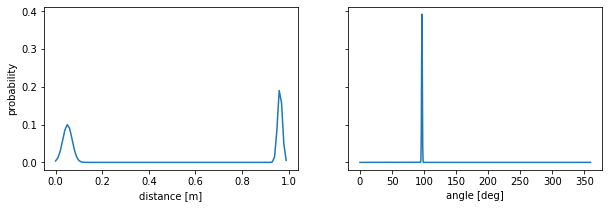

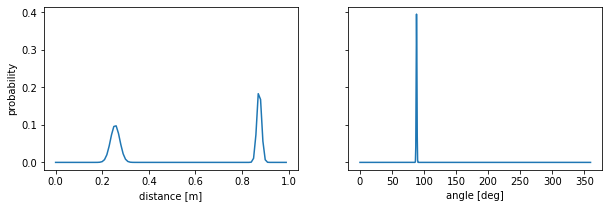

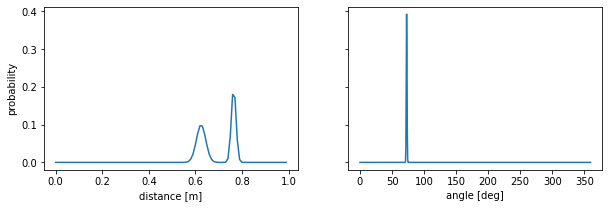

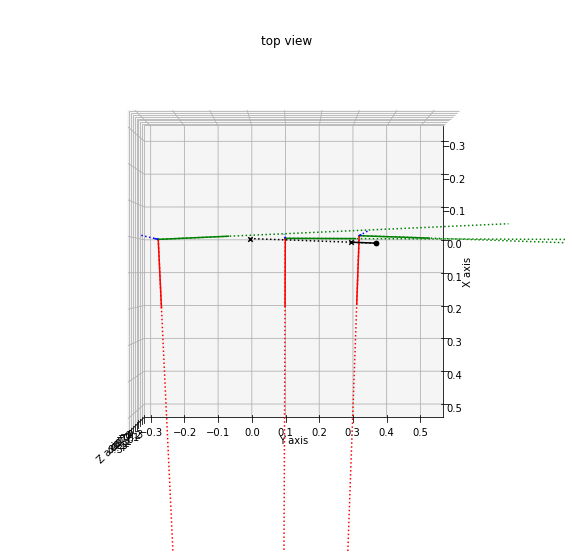

In [158]:
import sys
sys.path.append('../../src/audio_gtsam/')
from audio_gtsam.wall_backend import WallBackend
from helpers import WallSimulation, plot_all
import scipy.signal
import itertools
import plot

times = np.linspace(0, 1, 3)
n_outliers = 1

wall_backend = WallBackend()

plane = gtsam.OrientedPlane3(gtsam.Unit3([0, -1.0, 0]), 1)
#pose_0 = gtsam.Pose3(t=gtsam.Point3(0, 0, 0), r=gtsam.Rot3.Ypr(30/180*np.pi, 0, 0))
pose_0 = gtsam.Pose3()
wall_simulation = WallSimulation()
wall_simulation.initialize(plane, pose_0)
wall_simulation.set_velocities(linear_m_s=0.1, yaw_deg_s=0)

for t, time in enumerate(times):
    wall_simulation.move_until_time(time)
    
    pose_t = wall_simulation.real_pose()
    #pose_t = wall_simulation.measure_pose()
    #pose_t = wall_simulation.expected_pose()
    
    plane_meas, wall_angle, elevation, distance = wall_simulation.measure_plane()
    
    wall_backend.add_pose(r_world=pose_t.translation(), 
                          yaw=pose_t.rotation().yaw())
    
    # angle to wall as we measure it (between 0 and 2pi)
    azimuth = np.pi + wall_angle
    
    distance_values, distance_prob = get_distribution(distance, [0, 1], n_outliers=n_outliers)
    angle_values, angle_prob = get_distribution(azimuth, [0, 2*np.pi], n_outliers=0)
    
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(10, 3)
    axs[0].plot(distance_values, distance_prob)
    axs[0].set_ylabel('probability')
    axs[0].set_xlabel('distance [m]')
    axs[1].plot(angle_values * 180 / np.pi, angle_prob)
    axs[1].set_xlabel('angle [deg]')
    
    distance_estimates, distance_stds = get_estimates(distance_values, distance_prob)
    angle_estimates, angle_stds = get_estimates(angle_values, angle_prob)
    #print(distance_estimates, angle_estimates)
    
    for d_i, a_i in itertools.product(range(len(distance_estimates)), 
                                    range(len(angle_estimates))):
        distance = distance_estimates[d_i]
        azimuth = angle_estimates[a_i]
        noise = [distance_stds[d_i], angle_stds[a_i], 0]
        
        print(f"add wall estimate at {distance*100:.1f}cm, {azimuth*180/np.pi:.0f}deg")
        
        wall_angle = azimuth - np.pi
        wall_backend.add_plane(distance, wall_angle, plane_noise=noise)
        # add noise to angle
        #print(f"adding plane measurement: {distance*100:.0f}cm {wall_angle:5.0f}deg")
        #print(wall_backend.isam.getVariableIndex().nFactors())
        #print(wall_backend.isam.getVariableIndex())
        planes, poses = wall_backend.get_results()
plt.show()

plot_all(wall_backend.result, perspective=False, top=True, side=False)
plot.plot_trajectory(2, wall_backend.result, ls=":")
plt.show()

# DOA algorithms: passing spatial spectrum into GTSAM

Idea is to pass multiple sidelobes from spectrum as individual measurements to the same sound source.  